# **Final Stage - Face recognition**
### **Libraries**

In [1]:
# "Standard" libraries
import os
import pandas as pd
import numpy as np
import pickle
from PIL import Image, ImageOps
import time
import matplotlib.pyplot as plt

# Tensorflow and co
import tensorflow as tf
from tensorflow.keras import layers, models, applications

# Scikit learn and co
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Collect the source file location
dir_path = os.path.dirname(os.path.realpath(__name__))

c:\Users\arnol\Bureau\Université\Cours\Master Informatique - IA - EUR DS4H\AI Models and Applications\Project\AIModelsAndApplication20252026M1InfoIA\src\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


### **Import images**

In [3]:
# Import all the paths
df = pd.DataFrame(os.listdir(os.path.join(dir_path, "working")), columns=["path"])

# Process the path to get the name of the actor
df["name"] = df["path"].apply(lambda x: x.split("-")[0].removesuffix(".jpg").strip("0123456789_"))

# Create a mapping from an actor to a number
nameToIntDict:dict[int,str] = {name:i for i, name in enumerate(df["name"].unique())}
intToNameDict:dict[str,int] = {i:name for name, i in nameToIntDict.items()}

# Map the actor to its id
df["actorID"] = df["name"].map(nameToIntDict)

# Check if everything's fine
df.head()


,path,name,actorID
0,Adriana Lima0_0.jpg-person-nn-bb-44.4703826904...,Adriana Lima,0
1,Adriana Lima101_3.jpg-person-nn-bb-13.88998031...,Adriana Lima,0
2,Adriana Lima102_4.jpg-person-nn-bb-22.29929542...,Adriana Lima,0
3,Adriana Lima103_5.jpg-person-nn-bb-29.93367195...,Adriana Lima,0
4,Adriana Lima104_6.jpg-person-nn-bb-14.91487789...,Adriana Lima,0


### **Train Test Split**
We observe that the proportions within the the classes are not really uniform. Additionally taking randomly within the dataframe to create the training/test set may lead to some classes being overshadowed (not taken in either the training or the test set). For that, we will take a defined proportion of each classes within the training set. 

In [4]:
# Manipulate the seed and the random component
seed = 0
rng = np.random.RandomState(seed)
trainProportion = 0.8

# Initialise the training set and the test set
trainingSet:pd.DataFrame = []
testSet:pd.DataFrame = []

# For each actor id
for i in intToNameDict.keys():
    # Get the sub dataframe corresponding to the actor id
    subDF = df.loc[df["actorID"]==i]
    
    # Get trainProportion (80% by default) of the sub dataframe for training and the other for test set 
    trainIndices = rng.choice([True, False], subDF.shape[0], replace=True, p=[trainProportion, 1-trainProportion])
    trainingSet.append(subDF.loc[trainIndices])
    testSet.append(subDF.loc[~trainIndices])

# Merge the training set of all the actor, do the same for the test set
trainingSet = pd.concat(trainingSet).sample(frac=1, random_state=seed).reset_index()
testSet = pd.concat(testSet).sample(frac=1, random_state=seed).reset_index()

# Check if everything went good.
trainingSet.head()

,index,path,name,actorID
0,14129,Robert De Niro6_789.jpg-person-nn-bb-21.760091...,Robert De Niro,85
1,8592,Katharine Mcphee196_1599.jpg-person-nn-bb-12.8...,Katharine Mcphee,52
2,9688,Lili Reinhart108_2721.jpg-person-nn-bb-54.8482...,Lili Reinhart,58
3,394,Alexandra Daddario131_246.jpg-person-nn-bb-59....,Alexandra Daddario,2
4,8665,Katharine Mcphee69_1672.jpg-person-nn-bb-39.25...,Katharine Mcphee,52


### **Simple CNN** 

In [5]:
# https://www.tensorflow.org/tutorials/images/cnn?hl=fr
num_classes = len(intToNameDict)

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Dense layer
#model.add(layers.Flatten())
model.add(layers.GlobalAveragePooling2D()) # Flatten is too heavy with images of this size
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes))

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


c:\Users\arnol\Bureau\Université\Cours\Master Informatique - IA - EUR DS4H\AI Models and Applications\Project\AIModelsAndApplication20252026M1InfoIA\src\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 105)            │         6,825 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,729 (260.66 KB)

 Trainable params: 66,729 (260.66 KB)

 Non-trainable params: 0 (0.00 B)

### **Training model**
##### **A - Load images as batches**

In [27]:
def loadImageBatch(pathSet:pd.DataFrame, resizeDim:tuple[int] = (224, 224), equalize:bool = False, asRGB:bool = False, folder:str = "working") -> tuple[list[np.ndarray], list[int]]:
    
    # Initialise the batches
    imBatch = []
    imLabelBatch = []
    
    # For each element in the batch
    for row in pathSet.loc[:, ["path", "actorID"]].iterrows():
        # Get its label
        imLabelBatch.append(row[1].iloc[1])

        # Open the image
        with Image.open(os.path.join(dir_path, folder, row[1].iloc[0])) as im:
            if not asRGB:
                im = im.convert("L") # Convert to grayscale
            else:
                im = im.convert("RGB")
            im = im.resize(resizeDim) # Resize image
            if equalize:
                im = ImageOps.equalize() # Equalize the luminosity accross the pictures
            imBatch.append(np.asarray(im)/255.) # Transform into array and normaliser between 0 and 1

    return imBatch, imLabelBatch

# Check if it seems fine
loadImageBatch(trainingSet.iloc[:2,:])

([array([[0.15294118, 0.14901961, 0.14117647, ..., 0.28627451, 0.28235294,
          0.28235294],
         [0.14901961, 0.14509804, 0.1372549 , ..., 0.3254902 , 0.3254902 ,
          0.3254902 ],
         [0.14509804, 0.14117647, 0.12941176, ..., 0.37647059, 0.38039216,
          0.38431373],
         ...,
         [0.61960784, 0.60392157, 0.56862745, ..., 0.58039216, 0.45098039,
          0.38823529],
         [0.58823529, 0.56078431, 0.50196078, ..., 0.61176471, 0.47843137,
          0.41176471],
         [0.57254902, 0.5372549 , 0.46666667, ..., 0.63921569, 0.49411765,
          0.42352941]], shape=(224, 224)),
  array([[0.28627451, 0.28235294, 0.2745098 , ..., 0.26666667, 0.25490196,
          0.24705882],
         [0.2627451 , 0.25882353, 0.25882353, ..., 0.26666667, 0.25490196,
          0.25098039],
         [0.19607843, 0.2       , 0.21176471, ..., 0.27058824, 0.2627451 ,
          0.2627451 ],
         ...,
         [0.71372549, 0.70980392, 0.69803922, ..., 0.1254902 , 0.12549

##### **B-Training Loop** /!\ DO NOT RUN UNLESS YOU ARE READY TO SPEND 15 hours /!\ Load the model below instead.

In [ ]:
# Get the loss function with cross entropy
lossFunction = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Get the optimizer Adam
optimizer = tf.keras.optimizers.Adam()

# Optimize accuracy for training set
trainAccuracy = tf.keras.metrics.SparseCategoricalAccuracy()

# Function to manage the training step
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # Pass forward and loss computation
        logits = model(images, training = True)
        loss = lossFunction(labels, logits)
    
    # Compute and apply gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    # Update the training accuracy
    trainAccuracy.update_state(labels, logits)
    
    return loss

# Optimize validation accuracy (validation = training set)
validationAccuracy = tf.keras.metrics.SparseCategoricalAccuracy()

# Function to update the evaluation part (pass forward and test accuracy)
@tf.function
def val_step(images, labels) -> None:
    logits = model(images, training=False)
    validationAccuracy.update_state(labels, logits)
    



##### TRAINING LOOP
# Config
epochs = 200
batchSize = 100
batchNumber = float(trainingSet.shape[0]/batchSize).__ceil__()

# Records the performances over epochs
trainAccuracyPerEpoch = []
validationAccuracyPerEpoch = []
begin = time.time()

# For each epoch
for epoch in range(epochs):
    print(f"Epoch {epoch}/{epochs}")
    
    # Initialise everything
    trainAccuracy.reset_state()
    validationAccuracy.reset_state()
    epochLoss = 0.0
    
    # Go within Training loop. For each batch
    for batch in range(batchNumber):
        if batch % 10 == 0:
            print(f"Epoch {epoch}/{epochs}, Batch {batch}/{batchNumber}, [{time.time()-begin:.5f}s]")
        
        # Load the batch
        images, labels = loadImageBatch(trainingSet.iloc[batch*batchSize:(batch+1)*batchSize,:])
        
        # Perform the training step and update
        loss = train_step(tf.stack(images), tf.convert_to_tensor(labels, dtype=tf.int32))
        epochLoss += loss.numpy()
    
    # Update average loss on the epoch
    epochLoss /= batchNumber
    
    # Store metrics
    trainAccuracyPerEpoch.append(trainAccuracy.result().numpy())
    print(f"[TRAIN] Loss: {epochLoss:.4f}, Accuracy: {trainAccuracyPerEpoch[-1]:.4f} [{time.time()-begin:.5f}s]")
    
    # Evaluation loop (similar to the training loop above, but don't update the weights)
    for batch in range(batchNumber):
        if batch % 10 == 0:
            print(f"Epoch {epoch}/{epochs}, Batch {batch}/{batchNumber}, [{time.time()-begin:.5f}s]")
        images, labels = loadImageBatch(trainingSet.iloc[batch*batchSize:(batch+1)*batchSize,:])
        loss = val_step(tf.stack(images), tf.convert_to_tensor(labels, dtype=tf.int32))
    validationAccuracyPerEpoch.append(validationAccuracy.result().numpy())
    print(f"[VALIDATION] Accuracy: {validationAccuracyPerEpoch[-1]:.4f} [{time.time()-begin:.5f}s]")
    
    # Save the model at each epochs
    model.save(os.path.join(dir_path, "models", f"cnnEpoch{epoch}.keras"))
        


Epoch 0/200
Epoch 0/200, Batch 0/141, [0.00100s]
Epoch 0/200, Batch 10/141, [13.85599s]
Epoch 0/200, Batch 20/141, [26.79150s]
Epoch 0/200, Batch 30/141, [39.81769s]
Epoch 0/200, Batch 40/141, [53.25081s]
Epoch 0/200, Batch 50/141, [66.46687s]
Epoch 0/200, Batch 60/141, [78.89087s]
Epoch 0/200, Batch 70/141, [91.36499s]
Epoch 0/200, Batch 80/141, [103.85695s]
Epoch 0/200, Batch 90/141, [116.77760s]
Epoch 0/200, Batch 100/141, [130.86773s]
Epoch 0/200, Batch 110/141, [144.01929s]
Epoch 0/200, Batch 120/141, [158.46566s]
Epoch 0/200, Batch 130/141, [171.97554s]
Epoch 0/200, Batch 140/141, [185.91189s]
[TRAIN] Loss: 4.3694, Accuracy: 0.0410 [186.70331s]
Epoch 0/200, Batch 0/141, [186.70331s]
Epoch 0/200, Batch 10/141, [193.68768s]
Epoch 0/200, Batch 20/141, [200.00836s]
Epoch 0/200, Batch 30/141, [206.99730s]
Epoch 0/200, Batch 40/141, [213.91941s]
Epoch 0/200, Batch 50/141, [220.49309s]
Epoch 0/200, Batch 60/141, [227.48905s]
Epoch 0/200, Batch 70/141, [234.30234s]
Epoch 0/200, Batch 80/

##### **Save the final Model**
Since it was very long to train for 200 epochs (~15 hours), we also kept all the intermediary models to not lost anything...

In [ ]:
# Keep the final models
replace = False
#replace = True
if (not os.path.isfile(os.path.join(dir_path, "models", "finalCNNModel.keras"))) or replace:
    model.save(os.path.join(dir_path, "models", "finalCNNModel.keras"))

# Keep the accuracy per epochs
if replace or (not os.path.isfile(os.path.join(dir_path, "models", "accuracyPerEpoch.pkl"))):
    with open(os.path.join(dir_path, "models", "accuracyPerEpoch.pkl"), "bw") as file:
        pickle.dump({
            "trainingAcc":trainAccuracyPerEpoch,
            "validationAcc":validationAccuracyPerEpoch
        }, file)

##### **C - Evaluate**
##### **C.1 - Training vs Validation**

200
100
141


Text(0, 0.5, 'Accuracy')

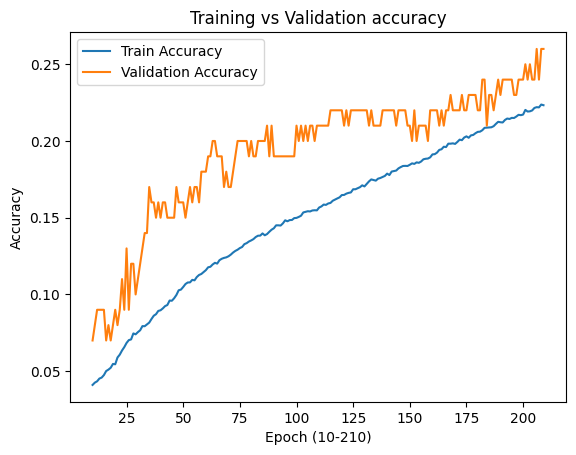

In [12]:
# Safety to retrieve the epoch, batch size and co
try: print(epochs)
except NameError: epochs = 200
try: print(batchSize)
except NameError: batchSize = 100
try: print(batchNumber)
except NameError: batchNumber = float(trainingSet.shape[0]/batchSize).__ceil__()

# Validation vs Accuracy
plt.plot(range(10,210), trainAccuracyPerEpoch, label="Train Accuracy")
# The maybe commented line below may work considering this was the old format we used to store validationAccPerEpoch. Use this one if the other do not work.
plt.plot(range(10,210), np.array(validationAccuracyPerEpoch)[[i*batchNumber for i in range(0, epochs)]], label="Validation Accuracy")
#plt.plot(validationAccuracyPerEpoch, label="Validation Accuracy")
plt.legend()
plt.title("Training vs Validation accuracy")
plt.xlabel("Epoch (10-210)")
plt.ylabel("Accuracy")

##### **C.2 - Test Set**
##### **C.2.1 - Predictions**

In [13]:
# Test set
# Config
batchSize = 100
batchNumber = float(testSet.shape[0]/batchSize).__ceil__()

# Initialise prediction and tests
y_pred = []
y_test = []

# For each batches
begin = time.time()
for batch in range(batchNumber):
    if batch % 10 == 0:
        print(f"Batch {batch}/{batchNumber}, [{time.time()-begin:.5f}s]")
        
    # Load the batch
    images, labels = loadImageBatch(testSet.iloc[batch*batchSize:(batch+1)*batchSize,:])
        
    # Infer the probability for each category
    logits = tf.nn.softmax(model(tf.stack(images)), axis=1)
        
    # Get the results infered by the model
    results = np.asarray(tf.argmax(logits, axis=1)).tolist()
    
    # Store the resuts
    y_pred.extend(results)
    y_test.extend(labels)

print(f"{time.time()-begin:.5f}s")

Batch 0/35, [0.00076s]
Batch 10/35, [9.38104s]
Batch 20/35, [18.77120s]
Batch 30/35, [27.99769s]
32.30422s


##### **C.2.2 - Confusion Matrix**

In [14]:
# Get the accuracy
print(f"The accuracy for this model is {accuracy_score(y_test, y_pred):.4f}.")

# Transform int to labels
y_testLab = [intToNameDict[i] for i in y_test]
y_predLab = [intToNameDict[i] for i in y_pred]

# Print the results
print(classification_report(y_testLab, y_predLab))

The accuracy for this model is 0.1690.
                        precision    recall  f1-score   support

          Adriana Lima       0.18      0.37      0.24        38
          Alex Lawther       0.37      0.27      0.31        26
    Alexandra Daddario       0.26      0.52      0.34        52
          Alvaro Morte       0.31      0.40      0.35        25
           Amanda Crew       0.00      0.00      0.00        24
          Andy Samberg       0.14      0.05      0.07        42
         Anne Hathaway       0.32      0.17      0.22        48
        Anthony Mackie       0.50      0.48      0.49        29
         Avril Lavigne       0.20      0.22      0.21        37
           Ben Affleck       0.04      0.04      0.04        28
            Bill Gates       0.50      0.36      0.42        22
          Bobby Morley       0.38      0.15      0.22        33
      Brenton Thwaites       0.11      0.05      0.07        37
        Brian J. Smith       0.00      0.00      0.00        24


c:\Users\arnol\Bureau\Université\Cours\Master Informatique - IA - EUR DS4H\AI Models and Applications\Project\AIModelsAndApplication20252026M1InfoIA\src\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\arnol\Bureau\Université\Cours\Master Informatique - IA - EUR DS4H\AI Models and Applications\Project\AIModelsAndApplication20252026M1InfoIA\src\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\arnol\Bureau\Université\Cours\Master Informatique - IA - EUR DS4H\AI Models

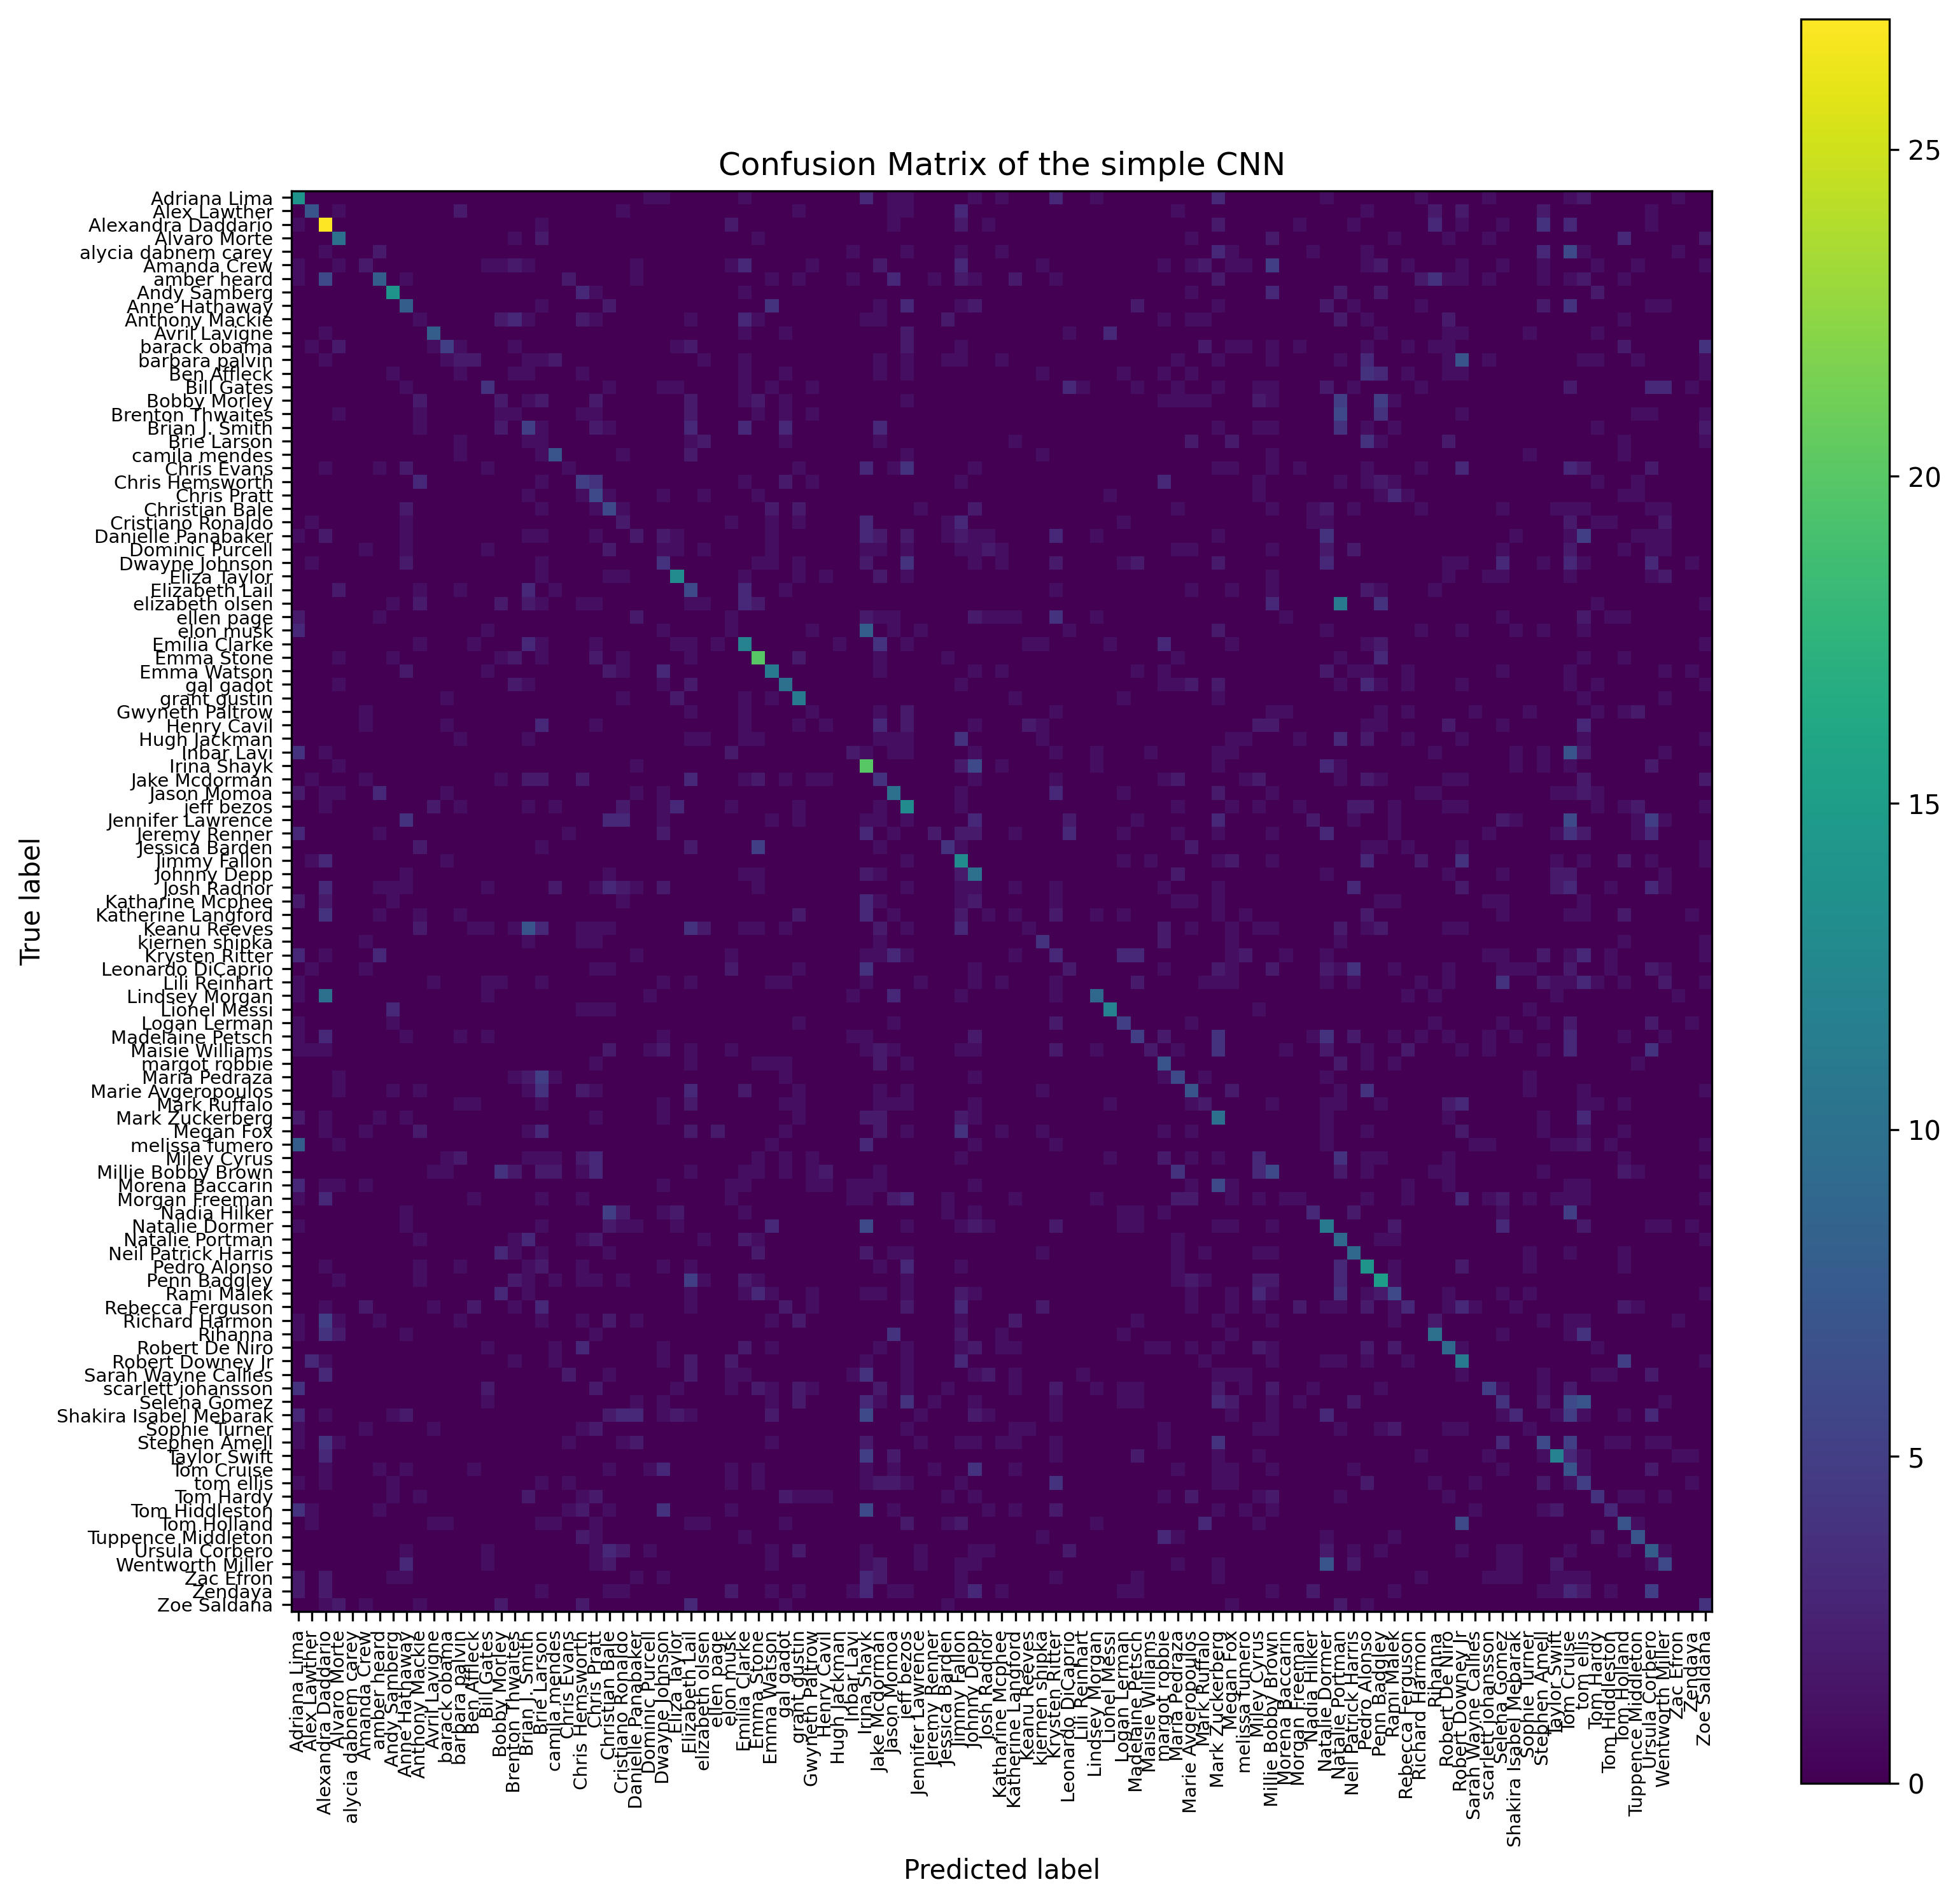

In [15]:
cm = confusion_matrix(y_testLab, y_predLab)
fig, ax = plt.subplots(figsize=(12, 12), dpi=300)
ConfusionMatrixDisplay(
    cm,
    display_labels=list(nameToIntDict.keys())
).plot(
    ax=ax,
    xticks_rotation="vertical",
    include_values=False
)
ax.set_title("Confusion Matrix of the simple CNN")
ax.tick_params(axis='both', labelsize=7)
fig.savefig("CNN Confusion Matrix")

##### **C.2.3 - Reload the model**

In [8]:
model = tf.keras.models.load_model(os.path.join(dir_path, "models", "finalCNNModel.keras"))
with open(os.path.join(dir_path, "models", "accuracyPerEpoch.pkl"), "rb") as file:
    trainAccuracyPerEpoch, validationAccuracyPerEpoch = pickle.load(file).values()

c:\Users\arnol\Bureau\Université\Cours\Master Informatique - IA - EUR DS4H\AI Models and Applications\Project\AIModelsAndApplication20252026M1InfoIA\src\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### **VGG-16 Retry**
#### **Import the model with weights**

In [16]:
# https://github.com/rcmalli/keras-vggface/releases/
modelVGG = applications.VGG16(weights=os.path.join(dir_path, "models", "rcmalli_vggface_tf_vgg16.h5"), classes=2622)
modelVGG.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 2622)           │    10,742,334 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,002,878 (553.14 MB)

 Trainable params: 145,002,878 (553.14 MB)

 Non-trainable params: 0 (0.00 B)

#### **Import the labels**

In [17]:
vggLabels:np.ndarray[str] = np.load(os.path.join(dir_path, "models", "rcmalli_vggface_labels_v1.npy"))
vggLabelsList = []
vggIntToName = {}

# Get a preprocessed list of recognised celebrities
for lab in vggLabels:
    tmp:str = lab.lower()
    tmp = tmp.strip()
    tmp = tmp.replace(".","")
    tmp = tmp.replace("_", " ")
    vggLabelsList.append(tmp.capitalize())
    
print(vggLabelsList)

['Aj buckley', 'Ar rahman', 'Aamir khan', 'Aaron staton', 'Aaron tveit', 'Aaron yoo', 'Abbie cornish', 'Abel ferrara', 'A p j abdul kalam', 'Abigail breslin', 'Abigail klein', 'Abigail spencer', 'Abraham benrubi', 'Adam baldwin', 'Adam beach', 'Adam brody', 'Adam buxton', 'Adam copeland', 'Adam driver', 'Adam g sevani', 'Adam garcia', 'Adam godley', 'Adam goldberg', 'Adam gregory', 'Adam hicks', 'Adam lambert', 'Adam levine', 'Adam rodriguez', 'Adelaide clemens', 'Adelaide kane', 'Adina porter', 'Aditya roy kapoor', 'Adrian grenier', 'Adrian paul', 'Adriana barraza', 'Adrianne curry', 'Adrianne palicki', 'Adrienne barbeau', 'Agyness deyn', 'Aida turturro', 'Aidan gillen', 'Aidan turner', 'Ana ivanovic', 'Ajay devgn', 'Akshay kumar', 'Alain delon', 'Alan alda', 'Alan cumming', 'Alan dale', 'Alan ladd', 'Alan rickman', 'Alan tudyk', 'Alba rohrwacher', 'Aldis hodge', 'Alessandra torresani', 'Alex borstein', 'Alex kingston', 'Alex newell', 'Alex pettyfer', 'Alex trebek', 'Alex wolff', 'Ale

#### **Compare with our labels**

In [18]:
absentCelebrity = []
vggNameToIntDict = {"[NR]":-1}
vggIntToNameDict = {-1:"[NR]"}

# Check for each celebrity if they can be recognised by vgg-faces
for name in nameToIntDict.keys():
    tmp:str = name
    tmp = tmp.capitalize()
    tmp = tmp.replace(".", "")
    if tmp in vggLabelsList:
        vggNameToIntDict[tmp] = vggLabelsList.index(tmp)
        vggIntToNameDict[vggLabelsList.index(tmp)] = tmp
    else:
        absentCelebrity.append(tmp)
    
print(f"There is {len(vggNameToIntDict)}/{num_classes} celebrities that are common in labels.")
print("Absent celebrities are:", *absentCelebrity, sep="\n")

There is 38/105 celebrities that are common in labels.
Absent celebrities are:
Adriana lima
Alex lawther
Alvaro morte
Alycia dabnem carey
Amanda crew
Amber heard
Avril lavigne
Barack obama
Barbara palvin
Ben affleck
Bill gates
Bobby morley
Brenton thwaites
Brian j smith
Brie larson
Camila mendes
Chris evans
Chris pratt
Christian bale
Cristiano ronaldo
Dominic purcell
Dwayne johnson
Eliza taylor
Elizabeth lail
Elizabeth olsen
Ellen page
Emilia clarke
Emma watson
Gal gadot
Grant gustin
Gwyneth paltrow
Henry cavil
Jennifer lawrence
Jessica barden
Johnny depp
Katherine langford
Keanu reeves
Kiernen shipka
Krysten ritter
Leonardo dicaprio
Lili reinhart
Lionel messi
Logan lerman
Madelaine petsch
Maisie williams
Maria pedraza
Melissa fumero
Millie bobby brown
Morgan freeman
Nadia hilker
Neil patrick harris
Pedro alonso
Rebecca ferguson
Richard harmon
Rihanna
Robert de niro
Robert downey jr
Scarlett johansson
Shakira isabel mebarak
Sophie turner
Stephen amell
Tom cruise
Tom ellis
Tom hardy
Tom

#### **Subset the main dataframe** (we don't need to train the model, it is already done)

In [19]:
# Get subset of actor which can be recognised by vgg-faces
vggDF = df[df["name"].str.capitalize().replace(".", "").isin(vggNameToIntDict.keys())].copy(deep=True)

# Process the name of the actor
vggDF["name"] = vggDF["name"].str.capitalize().replace(".","")

# Replace the actorID with the new one
vggDF["actorID"] = vggDF["name"].map(vggNameToIntDict)

# Check if the changes seems corrects
vggDF.tail()
print(vggDF.shape[0])

6131


#### **Test VGG on the subset**
#### **A - Prediction**

In [21]:
# Test set
# Config
batchSize = 100
batchNumber = float(vggDF.shape[0]/batchSize).__ceil__()

# Initialise prediction and tests
y_predVGG = []
y_testVGG = []

# For each batches
begin = time.time()
for batch in range(batchNumber):
    print(f"Batch {batch}/{batchNumber}, [{time.time()-begin:.5f}s]")
        
    # Load the batch
    images, labels = loadImageBatch(vggDF.iloc[batch*batchSize:(batch+1)*batchSize,:], asRGB=True)
        
    # Infer the probability for each category
    logits = tf.nn.softmax(modelVGG(tf.stack(images)), axis=1)
        
    # Get the results infered by the model
    results = np.asarray(tf.argmax(logits, axis=1)).tolist()
    
    # Store the resuts
    y_predVGG.extend(results)
    y_testVGG.extend(labels) 

Batch 0/62, [0.00000s]
Batch 1/62, [12.95981s]
Batch 2/62, [23.65779s]
Batch 3/62, [34.14393s]
Batch 4/62, [44.91986s]
Batch 5/62, [55.45688s]
Batch 6/62, [66.56867s]
Batch 7/62, [77.20956s]
Batch 8/62, [88.25148s]
Batch 9/62, [99.35668s]
Batch 10/62, [110.15225s]
Batch 11/62, [120.77246s]
Batch 12/62, [131.41579s]
Batch 13/62, [142.37212s]
Batch 14/62, [153.10613s]
Batch 15/62, [163.82548s]
Batch 16/62, [174.83334s]
Batch 17/62, [186.07506s]
Batch 18/62, [197.10458s]
Batch 19/62, [208.03013s]
Batch 20/62, [218.62081s]
Batch 21/62, [229.21400s]
Batch 22/62, [240.01670s]
Batch 23/62, [250.61154s]
Batch 24/62, [261.31686s]
Batch 25/62, [272.19624s]
Batch 26/62, [282.84475s]
Batch 27/62, [293.89865s]
Batch 28/62, [305.31944s]
Batch 29/62, [316.36836s]
Batch 30/62, [327.46163s]
Batch 31/62, [338.84090s]
Batch 32/62, [349.48499s]
Batch 33/62, [361.00424s]
Batch 34/62, [372.34528s]
Batch 35/62, [383.26422s]
Batch 36/62, [393.85690s]
Batch 37/62, [404.92584s]
Batch 38/62, [415.90755s]
Batch 3

#### **B - Confusion Matrix**

In [23]:
# Transform int to labels
y_testVGGLab = [vggIntToNameDict.get(i, "[NR]") for i in y_testVGG]
y_predVGGLab = [vggIntToNameDict.get(i, "[NR]") for i in y_predVGG]

# Get the accuracy
print(f"The accuracy for this model is {accuracy_score(y_testVGGLab, y_predVGGLab):.4f}.")

# Print the results
print(classification_report(y_testVGGLab, y_predVGGLab))

The accuracy for this model is 0.6637.
                     precision    recall  f1-score   support

 Alexandra daddario       1.00      0.83      0.91       225
       Andy samberg       1.00      0.36      0.53       196
      Anne hathaway       1.00      0.69      0.82       203
     Anthony mackie       1.00      0.79      0.88       124
    Chris hemsworth       1.00      0.70      0.83       159
 Danielle panabaker       1.00      0.59      0.74       181
          Elon musk       0.00      0.00      0.00       135
         Emma stone       1.00      0.56      0.72       139
       Hugh jackman       1.00      0.69      0.82       178
         Inbar lavi       1.00      0.64      0.78       127
        Irina shayk       1.00      0.78      0.87       156
      Jake mcdorman       1.00      0.73      0.84       159
        Jason momoa       1.00      0.60      0.75       182
         Jeff bezos       0.00      0.00      0.00       106
      Jeremy renner       1.00      0.80     

c:\Users\arnol\Bureau\Université\Cours\Master Informatique - IA - EUR DS4H\AI Models and Applications\Project\AIModelsAndApplication20252026M1InfoIA\src\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\arnol\Bureau\Université\Cours\Master Informatique - IA - EUR DS4H\AI Models and Applications\Project\AIModelsAndApplication20252026M1InfoIA\src\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\arnol\Bureau\Université\Cours\Master Informatique - IA - EUR DS4H\AI Models and App

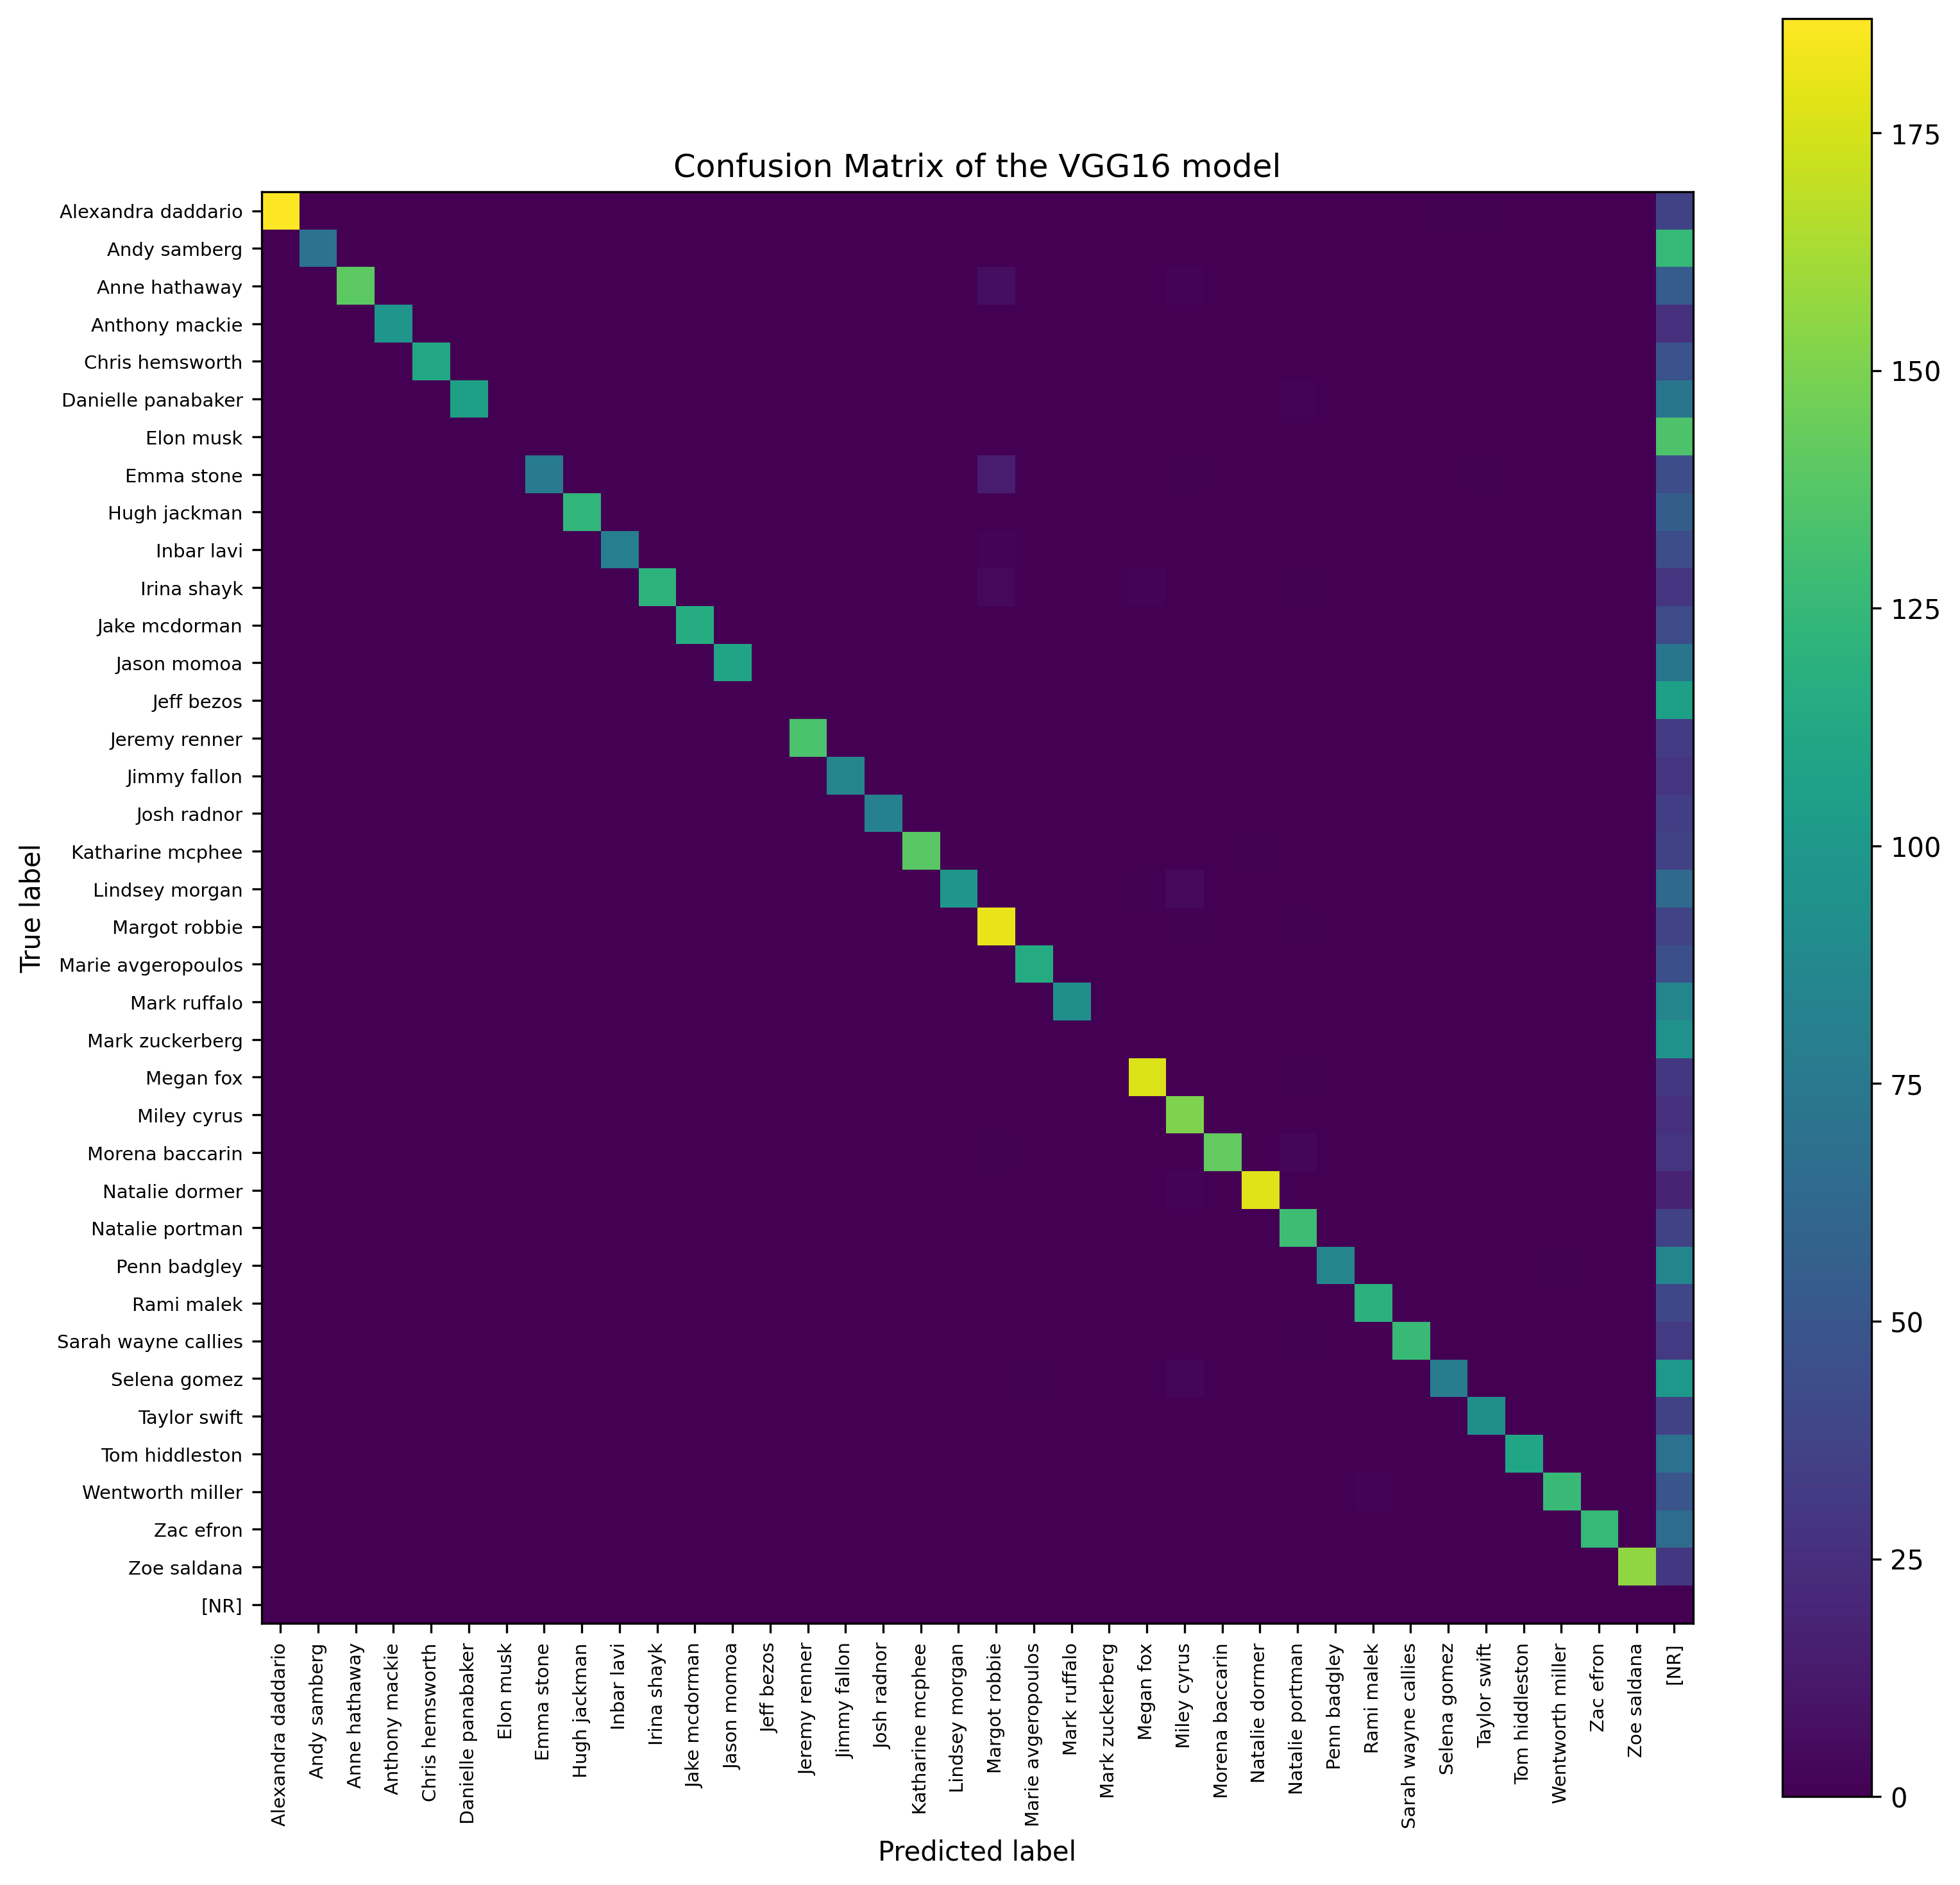

In [24]:
cm = confusion_matrix(y_testVGGLab, y_predVGGLab)
fig, ax = plt.subplots(figsize=(12, 12), dpi=300)
ConfusionMatrixDisplay(
    cm,
    display_labels=sorted(set(y_testVGGLab) | set(y_predVGGLab)) # For some reason, "[NR]" was leading to error, so we needed to do that to complete the set of labels
).plot(
    ax=ax,
    xticks_rotation="vertical",
    include_values=False
)
ax.set_title("Confusion Matrix of the VGG16 model")
ax.tick_params(axis='both', labelsize=7)
fig.savefig("VGG16 Confusion Matrix")

### **RGB VGG-Faces**
#### **Import Data**

In [25]:
# Import all the paths
dfRGB = pd.DataFrame(os.listdir(os.path.join(dir_path, "working_coloured")), columns=["path"])

# Process the path to get the name of the actor
dfRGB["name"] = dfRGB["path"].apply(lambda x: x.split("-")[0].removesuffix(".jpg").strip("0123456789_"))

# Create a mapping from an actor to a number
nameToIntDict:dict[int,str] = {name:i for i, name in enumerate(dfRGB["name"].unique())}
intToNameDict:dict[str,int] = {i:name for name, i in nameToIntDict.items()}

# Map the actor to its id
dfRGB["actorID"] = dfRGB["name"].map(nameToIntDict)

# Check if everything's fine
dfRGB.head()

,path,name,actorID
0,Adriana Lima0_0.jpg-person-nn-bb-44.4703826904...,Adriana Lima,0
1,Adriana Lima101_3.jpg-person-nn-bb-13.88998031...,Adriana Lima,0
2,Adriana Lima102_4.jpg-person-nn-bb-22.29929542...,Adriana Lima,0
3,Adriana Lima103_5.jpg-person-nn-bb-29.93367195...,Adriana Lima,0
4,Adriana Lima104_6.jpg-person-nn-bb-14.91487789...,Adriana Lima,0


#### **Build the model and subset dataset**

In [26]:
# Build the model
modelVGGRGB = applications.VGG16(weights=os.path.join(dir_path, "models", "rcmalli_vggface_tf_vgg16.h5"), classes=2622)
modelVGGRGB.summary()

# Get subset of actor which can be recognised by vgg-faces
vggDFRGB = dfRGB[dfRGB["name"].str.capitalize().replace(".", "").isin(vggNameToIntDict.keys())].copy(deep=True)

# Process the name of the actor
vggDFRGB["name"] = vggDFRGB["name"].str.capitalize().replace(".","")

# Replace the actorID with the new one
vggDFRGB["actorID"] = vggDFRGB["name"].map(vggNameToIntDict)

# Check if the changes seems corrects
vggDFRGB.tail()
print(vggDFRGB.shape[0])

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 2622)           │    10,742,334 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,002,878 (553.14 MB)

 Trainable params: 145,002,878 (553.14 MB)

 Non-trainable params: 0 (0.00 B)

6131


#### **RGB Inferences**

In [28]:
# Test set
# Config
batchSize = 100
batchNumber = float(vggDFRGB.shape[0]/batchSize).__ceil__()

# Initialise prediction and tests
y_predVGGRGB = []
y_testVGGRGB = []

# For each batches
begin = time.time()
for batch in range(batchNumber):
    print(f"Batch {batch}/{batchNumber}, [{time.time()-begin:.5f}s]")
        
    # Load the batch
    images, labels = loadImageBatch(vggDFRGB.iloc[batch*batchSize:(batch+1)*batchSize,:], asRGB=True, folder="working_coloured")
        
    # Infer the probability for each category
    logits = tf.nn.softmax(modelVGGRGB(tf.stack(images)), axis=1)
        
    # Get the results infered by the model
    results = np.asarray(tf.argmax(logits, axis=1)).tolist()
    
    # Store the resuts
    y_predVGGRGB.extend(results)
    y_testVGGRGB.extend(labels), 

Batch 0/62, [0.00000s]
Batch 1/62, [12.21111s]
Batch 2/62, [23.01825s]
Batch 3/62, [33.77673s]
Batch 4/62, [43.94748s]
Batch 5/62, [54.16866s]
Batch 6/62, [64.54863s]
Batch 7/62, [74.86826s]
Batch 8/62, [85.16914s]
Batch 9/62, [95.58427s]
Batch 10/62, [105.79153s]
Batch 11/62, [116.20197s]
Batch 12/62, [126.53605s]
Batch 13/62, [137.02824s]
Batch 14/62, [147.83349s]
Batch 15/62, [158.63349s]
Batch 16/62, [169.07856s]
Batch 17/62, [180.08780s]
Batch 18/62, [191.23429s]
Batch 19/62, [201.72583s]
Batch 20/62, [212.17393s]
Batch 21/62, [222.85303s]
Batch 22/62, [233.19880s]
Batch 23/62, [243.66091s]
Batch 24/62, [254.55209s]
Batch 25/62, [267.47762s]
Batch 26/62, [278.95153s]
Batch 27/62, [289.76584s]
Batch 28/62, [300.94967s]
Batch 29/62, [311.57935s]
Batch 30/62, [322.35888s]
Batch 31/62, [332.74985s]
Batch 32/62, [342.84257s]
Batch 33/62, [352.98308s]
Batch 34/62, [363.26347s]
Batch 35/62, [373.39670s]
Batch 36/62, [383.78344s]
Batch 37/62, [394.35596s]
Batch 38/62, [405.21923s]
Batch 3

#### **RGB Confusion Matrix**

In [29]:
# Transform int to labels
y_testVGGLabRGB = [vggIntToNameDict.get(i, "[NR]") for i in y_testVGGRGB]
y_predVGGLabRGB = [vggIntToNameDict.get(i, "[NR]") for i in y_predVGGRGB]

# Get the accuracy
print(f"The accuracy for this model is {accuracy_score(y_testVGGLabRGB, y_predVGGLabRGB):.4f}.")

# Print the results
print(classification_report(y_testVGGLabRGB, y_predVGGLabRGB))

The accuracy for this model is 0.6423.
                     precision    recall  f1-score   support

 Alexandra daddario       1.00      0.81      0.90       225
       Andy samberg       1.00      0.37      0.54       196
      Anne hathaway       1.00      0.70      0.82       203
     Anthony mackie       1.00      0.73      0.84       124
    Chris hemsworth       1.00      0.69      0.81       159
 Danielle panabaker       1.00      0.57      0.73       181
          Elon musk       0.00      0.00      0.00       135
         Emma stone       0.99      0.53      0.69       139
       Hugh jackman       1.00      0.68      0.81       178
         Inbar lavi       1.00      0.62      0.77       127
        Irina shayk       1.00      0.76      0.87       156
      Jake mcdorman       1.00      0.70      0.82       159
        Jason momoa       1.00      0.56      0.72       182
         Jeff bezos       0.00      0.00      0.00       106
      Jeremy renner       1.00      0.78     

c:\Users\arnol\Bureau\Université\Cours\Master Informatique - IA - EUR DS4H\AI Models and Applications\Project\AIModelsAndApplication20252026M1InfoIA\src\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\arnol\Bureau\Université\Cours\Master Informatique - IA - EUR DS4H\AI Models and Applications\Project\AIModelsAndApplication20252026M1InfoIA\src\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\arnol\Bureau\Université\Cours\Master Informatique - IA - EUR DS4H\AI Models and App

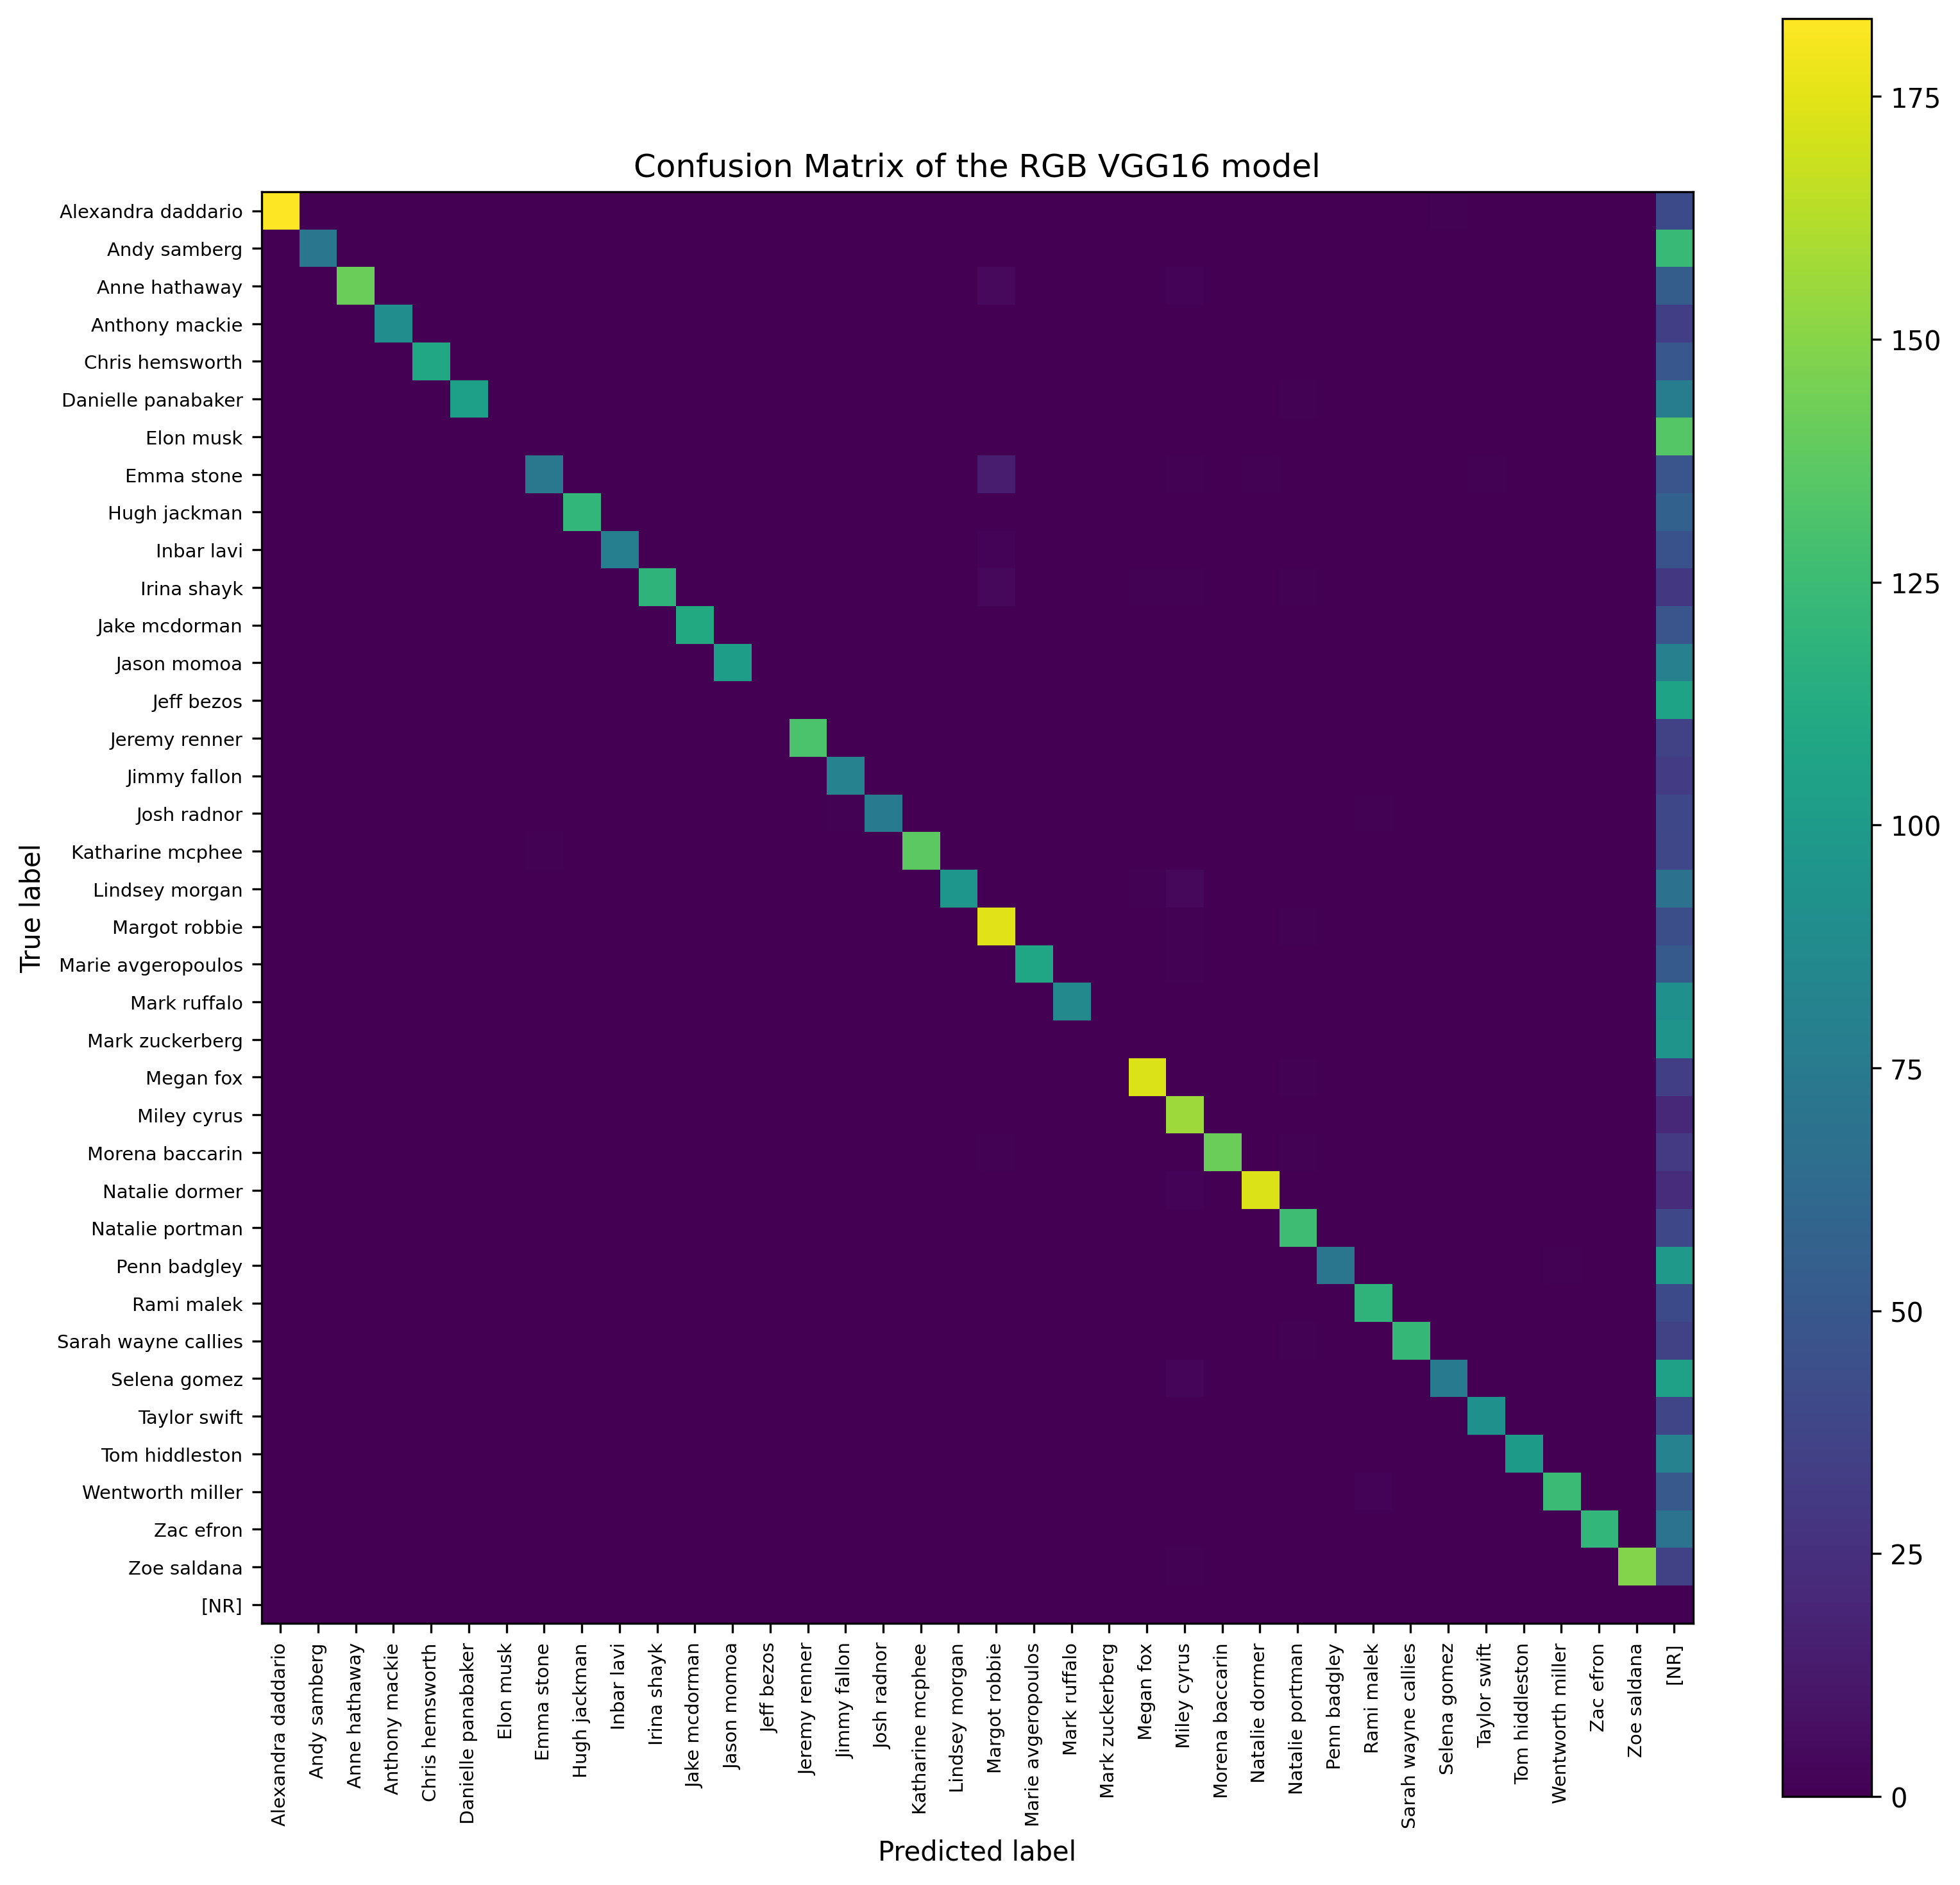

In [30]:
cm = confusion_matrix(y_testVGGLabRGB, y_predVGGLabRGB)
fig, ax = plt.subplots(figsize=(12, 12), dpi=300)
ConfusionMatrixDisplay(
    cm,
    display_labels=sorted(set(y_testVGGLabRGB) | set(y_predVGGLabRGB)) # For some reason, "[NR]" was leading to error, so we needed to do that to complete the set of labels
).plot(
    ax=ax,
    xticks_rotation="vertical",
    include_values=False
)
ax.set_title("Confusion Matrix of the RGB VGG16 model")
ax.tick_params(axis='both', labelsize=7)
fig.savefig("RGB VGG16 Confusion Matrix")